In [54]:
import pandas as pd
import numpy as np
from collections import Counter
import shap
from sklearn.ensemble import RandomForestClassifier

/Users/nicolae.mogage/Uni/machine-learning-sp/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [55]:
def load_dataset(filepath):
    data = pd.read_csv(filepath)
    x = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    feature_names = data.columns[:-1]

    min_vals = np.min(x, axis=0)
    max_vals = np.max(x, axis=0)
    x_scaled = (x - min_vals) / (max_vals - min_vals)

    bmi_idx = np.where(feature_names == 'BMI')[0][0]
    skin_thickness_idx = np.where(feature_names == 'SkinThickness')[0][0]
    insulin_idx = np.where(feature_names == 'Insulin')[0][0]

    for idx in [bmi_idx, skin_thickness_idx, insulin_idx]:
        for outcome in np.unique(y):
            mask = (y == outcome) & (x_scaled[:, idx] > 0)
            mean_value = np.mean(x_scaled[mask, idx])
            x_scaled[(y == outcome) & (x_scaled[:, idx] == 0), idx] = mean_value

    return x_scaled, y, feature_names

In [110]:
def gini_impurity(y):
    counts = Counter(y)
    total_samples = len(y)
    impurity = 1.0
    for cls, count in counts.items():
        prob = count / total_samples
        impurity -= prob ** 2
    return impurity


def split_dataset(X, y, feature_idx, threshold):
    left_mask = X[:, feature_idx] <= threshold
    right_mask = X[:, feature_idx] > threshold
    return X[left_mask], X[right_mask], y[left_mask], y[right_mask]


class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y, depth=0):
        num_samples, num_features = X.shape
        if depth == self.max_depth or num_samples < self.min_samples_split or len(set(y)) == 1:
            return Counter(y).most_common(1)[0][0]

        best_feature, best_threshold, best_gini = None, None, float('inf')
        for feature_idx in range(num_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                _, _, y_left, y_right = split_dataset(X, y, feature_idx, threshold)
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                gini = (
                        len(y_left) / num_samples * gini_impurity(y_left) +
                        len(y_right) / num_samples * gini_impurity(y_right)
                )
                if gini < best_gini:
                    best_feature, best_threshold, best_gini = feature_idx, threshold, gini

        if best_feature is None:
            return Counter(y).most_common(1)[0][0]

        X_left, X_right, y_left, y_right = split_dataset(X, y, best_feature, best_threshold)
        left_subtree = self.fit(X_left, y_left, depth + 1)
        right_subtree = self.fit(X_right, y_right, depth + 1)

        return {"feature": best_feature, "threshold": best_threshold, "left": left_subtree, "right": right_subtree}

    def predict_sample(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        feature = tree["feature"]
        threshold = tree["threshold"]
        if x[feature] <= threshold:
            return self.predict_sample(x, tree["left"])
        else:
            return self.predict_sample(x, tree["right"])

    def predict(self, X):
        return np.array([self.predict_sample(x, self.tree) for x in X])

    def get_params(self, deep=True):
        return {
            "max_depth": self.max_depth,
            "min_samples_split": self.min_samples_split
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, max_features="sqrt"):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        self.trees = []
        n_features = X.shape[1]
        max_features = (
            int(np.sqrt(n_features)) if self.max_features == "sqrt" else n_features
        )

        for _ in range(self.n_estimators):
            X_sample, y_sample = self.bootstrap_sample(X, y)
            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)

            feature_indices = np.random.choice(n_features, max_features, replace=False)
            X_sample_reduced = X_sample[:, feature_indices]

            tree.tree = tree.fit(X_sample_reduced, y_sample)
            self.trees.append((tree, feature_indices))

    def predict(self, X):
        predictions = []
        for tree, feature_indices in self.trees:
            X_reduced = X[:, feature_indices]
            predictions.append(tree.predict(X_reduced))
        predictions = np.array(predictions).T
        final_predictions = [Counter(row).most_common(1)[0][0] for row in predictions]
        return np.array(final_predictions)

    def predict_proba(self, X):
        predictions = []
        for tree, feature_indices in self.trees:
            X_reduced = X[:, feature_indices]
            predictions.append(tree.predict(X_reduced))
        predictions = np.array(predictions).T

        all_classes = np.array([0, 1])

        probas = []
        for row in predictions:
            counts = Counter(row)
            total = sum(counts.values())
            row_probas = [counts[cls] / total for cls in all_classes]
            probas.append(row_probas)

        return np.array(probas)

    def get_params(self, deep=True):
        return {
            "n_estimators": self.n_estimators,
            "max_depth": self.max_depth,
            "min_samples_split": self.min_samples_split,
            "max_features": self.max_features
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [107]:
def compute_roc_curve(y_true, y_pred_prob):
    thresholds = np.flip(np.unique(y_pred_prob))
    tpr_list = []
    fpr_list = []

    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)

        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        tn = np.sum((y_pred == 0) & (y_true == 0))

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return tpr_list, fpr_list


def compute_roc_auc(y_true, y_pred_prob):
    tpr_list, fpr_list = compute_roc_curve(y_true, y_pred_prob)

    fpr = np.array(fpr_list)
    tpr = np.array(tpr_list)

    return np.trapezoid(tpr, fpr)


def compute_pr_curve(y_true, y_pred_prob):
    thresholds = np.flip(np.unique(y_pred_prob))
    precision_list = [1]
    recall_list = [0]

    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)

        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        precision_list.append(precision)
        recall_list.append(recall)

    return precision_list, recall_list


def compute_pr_auc(y_true, y_pred_prob):
    precision_list, recall_list = compute_pr_curve(y_true, y_pred_prob)

    recall = np.array(recall_list)
    precision = np.array(precision_list)

    return np.trapezoid(precision, recall)


def compute_metrics(y_true, y_pred, y_pred_proba):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    auc_score = compute_roc_auc(y_true, y_pred_proba)
    auprc_score = compute_pr_auc(y_true, y_pred_proba)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1_score,
        "AUC": auc_score,
        "AUPRC": auprc_score
    }


def print_metrics(model, metrics_list):
    print(f"Model: {model}")

    for key in metrics_list[0].keys():
        print(f"{key}: {metrics_list[0][key]:.2f} +/- {metrics_list[1][key]:.2f} (95% CI: {metrics_list[2][key][0]:.2f} - {metrics_list[2][key][1]:.2f})")

def average_metrics(metrics_list):
    aggregated_metrics = {key: [] for key in metrics_list[0].keys()}

    for metrics in metrics_list:
        for key, value in metrics.items():
            aggregated_metrics[key].append(value)

    number_of_folds = len(metrics_list)
    mean_metrics = {key: np.mean(values) for key, values in aggregated_metrics.items()}
    std_metrics = {key: np.std(values) for key, values in aggregated_metrics.items()}
    margin_errors = {key: 1.96 * std_metrics[key] / np.sqrt(number_of_folds) for key in std_metrics.keys()}
    ci_metrics = {key: (mean_metrics[key] - margin_errors[key], mean_metrics[key] + margin_errors[key]) for key in mean_metrics.keys()}

    return [mean_metrics, std_metrics, ci_metrics]

In [120]:
def explain_with_shap(model, X_train, X_test):
    def predict_proba_fn(X):
        return model.predict_proba(X)[:, 1]

    explainer = shap.KernelExplainer(predict_proba_fn, X_train[:30])
    shap_values = explainer.shap_values(X_test, nsamples=30)

    return shap_values


def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predictions_proba = model.predict_proba(X_test)[:, 1]
    return compute_metrics(y_test, predictions, predictions_proba)


def cross_validate(X, y, k=5, shuffle=True, random_state=None):
    X = np.array(X)
    y = np.array(y)

    if shuffle:
        if random_state is not None:
            np.random.seed(random_state)
        indices = np.random.permutation(len(y))
        X = X[indices]
        y = y[indices]

    fold_size = len(y) // k
    folds = []
    for i in range(k):
        start = i * fold_size
        end = start + fold_size
        folds.append((X[start:end], y[start:end]))

    all_metrics = []
    all_sklearn_metrics = []
    all_shap_values = []
    all_sklearn_shap_values = []
    all_x_test = []

    for i in range(k):
        X_test, y_test = folds[i]
        X_train = np.vstack([folds[j][0] for j in range(k) if j != i])
        y_train = np.hstack([folds[j][1] for j in range(k) if j != i])

        model = RandomForest(n_estimators=500, max_depth=10)
        sklearn_model = RandomForestClassifier(n_estimators=250, max_depth=10)

        all_metrics.append(evaluate_model(model, X_train, X_test, y_train, y_test))
        all_sklearn_metrics.append(evaluate_model(sklearn_model, X_train, X_test, y_train, y_test))

        all_shap_values.append(explain_with_shap(model, X_train, X_test))
        all_sklearn_shap_values.append(explain_with_shap(sklearn_model, X_train, X_test))
        all_x_test.append(X_test)

    print_metrics("Random Forest", average_metrics(all_metrics))
    print_metrics("Random Forest (sklearn)", average_metrics(all_sklearn_metrics))

    all_shap_values = np.vstack(all_shap_values)
    all_sklearn_shap_values = np.vstack(all_sklearn_shap_values)
    all_x_test = np.vstack(all_x_test)
    shap.summary_plot(all_shap_values, all_x_test, feature_names=feature_names)
    shap.summary_plot(all_sklearn_shap_values, all_x_test, feature_names=feature_names)

In [119]:
param_grid = {
    "n_estimators": [50, 100, 250, 500],
    "max_depth": [None, 10, 15, 20]
}

def grid_search(X, y, param_grid, k=5, shuffle=True, random_state=None):
    X = np.array(X)
    y = np.array(y)

    if shuffle:
        if random_state is not None:
            np.random.seed(random_state)
        indices = np.random.permutation(len(y))
        X = X[indices]
        y = y[indices]

    fold_size = len(y) // k
    folds = []
    for i in range(k):
        start = i * fold_size
        end = start + fold_size
        folds.append((X[start:end], y[start:end]))

    best_params = None
    best_score = 0

    best_sklearn_params = None
    best_sklearn_score = 0

    for n_estimators in param_grid["n_estimators"]:
        for max_depth in param_grid["max_depth"]:
            all_metrics = []
            all_sklearn_metrics = []


            print(f"n_estimators={n_estimators}, max_depth={max_depth}")
            for i in range(k):
                X_test, y_test = folds[i]
                X_train = np.vstack([folds[j][0] for j in range(k) if j != i])
                y_train = np.hstack([folds[j][1] for j in range(k) if j != i])

                model = RandomForest(n_estimators=n_estimators, max_depth=max_depth)
                sklearn_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
                all_metrics.append(evaluate_model(model, X_train, X_test, y_train, y_test))
                all_sklearn_metrics.append(evaluate_model(sklearn_model, X_train, X_test, y_train, y_test))

            metrics = average_metrics(all_metrics)
            sklearn_metrics = average_metrics(all_sklearn_metrics)

            score = metrics[0]["AUC"]
            sklearn_score = sklearn_metrics[0]["AUC"]

            if score > best_score:
                best_score = score
                best_params = {"n_estimators": n_estimators, "max_depth": max_depth}

            if sklearn_score > best_sklearn_score:
                best_sklearn_score = sklearn_score
                best_sklearn_params = {"n_estimators": n_estimators, "max_depth": max_depth}

    return best_params, best_sklearn_params


features, output, feature_names = load_dataset('../data/diabetes_super.csv')
print(grid_search(features, output, param_grid))

n_estimators=50, max_depth=None
n_estimators=50, max_depth=10
n_estimators=50, max_depth=15
n_estimators=50, max_depth=20
n_estimators=100, max_depth=None
n_estimators=100, max_depth=10
n_estimators=100, max_depth=15
n_estimators=100, max_depth=20
n_estimators=250, max_depth=None
n_estimators=250, max_depth=10
n_estimators=250, max_depth=15
n_estimators=250, max_depth=20
n_estimators=500, max_depth=None
n_estimators=500, max_depth=10
n_estimators=500, max_depth=15
n_estimators=500, max_depth=20
({'n_estimators': 500, 'max_depth': 10}, {'n_estimators': 250, 'max_depth': 10})


 32%|███▏      | 49/153 [00:00<00:01, 64.05it/s]/Users/nicolae.mogage/Uni/machine-learning-sp/venv/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=5.530e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
100%|██████████| 153/153 [00:02<00:00, 63.15it/s]


Model: Random Forest
Accuracy: 0.85 +/- 0.03 (95% CI: 0.82 - 0.88)
Precision: 0.90 +/- 0.04 (95% CI: 0.87 - 0.93)
Recall: 0.64 +/- 0.05 (95% CI: 0.59 - 0.69)
Specificity: 0.96 +/- 0.01 (95% CI: 0.95 - 0.97)
F1 Score: 0.75 +/- 0.03 (95% CI: 0.72 - 0.77)
AUC: 0.93 +/- 0.02 (95% CI: 0.92 - 0.95)
AUPRC: 0.89 +/- 0.03 (95% CI: 0.86 - 0.91)
Model: Random Forest (sklearn)
Accuracy: 0.88 +/- 0.02 (95% CI: 0.87 - 0.90)
Precision: 0.84 +/- 0.03 (95% CI: 0.82 - 0.87)
Recall: 0.82 +/- 0.03 (95% CI: 0.79 - 0.85)
Specificity: 0.92 +/- 0.01 (95% CI: 0.91 - 0.93)
F1 Score: 0.83 +/- 0.02 (95% CI: 0.82 - 0.84)
AUC: 0.94 +/- 0.01 (95% CI: 0.94 - 0.95)
AUPRC: 0.91 +/- 0.01 (95% CI: 0.90 - 0.92)


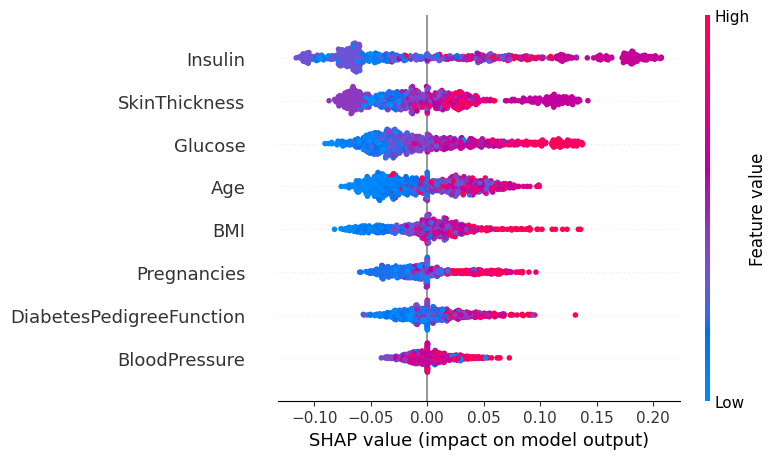

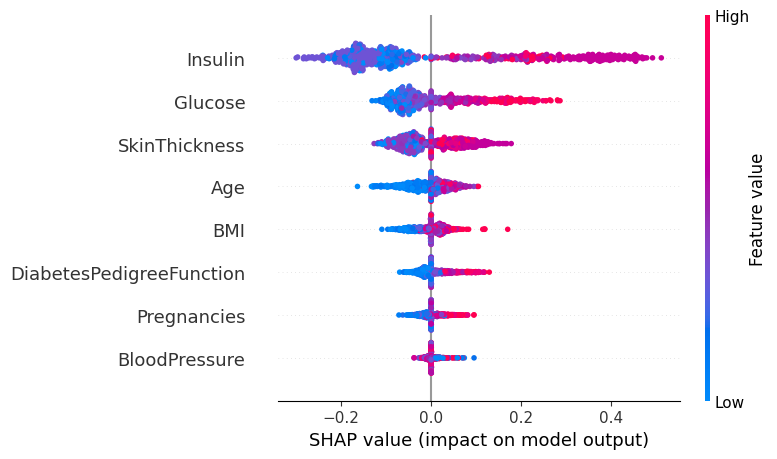

In [121]:
features, output, feature_names = load_dataset('../data/diabetes_super.csv')

cross_validate(features, output, k=5)